# Data Visualization of Economic Data
## Analyzing population
**Kinga Chodorowska**

The data in my project comes from sources:
https://geojson.io/#map=5.26/52.016/19.139
https://stat.gov.pl/obszary-tematyczne/ludnosc/ludnosc/powierzchnia-i-ludnosc-w-przekroju-terytorialnym-w-2020-roku,7,17.html
https://www.polskawliczbach.pl/Wojewodztwa

The first step is to import required libraries.

In [58]:
# Importing required Libraries
import geopandas as gpd
import pandas as pd
import folium
import json
from folium.features import GeoJson, GeoJsonTooltip, GeoJsonPopup
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

Then enter the data from the file.

In [16]:
# Input data
fname = 'C:/Users/Kinga Chodorowska/Downloads/mygeodata/map-polygon.shp'
pol_voivo = gpd.read_file(fname)
pol_voivo.head()

,CCA_1,CCN_1,ENGTYPE_1,HASC_1,ID_0,ID_1,ISO,NAME_0,NAME_1,NL_NAME_1,TYPE_1,name,pop,cities_no,geometry
0,None,0,Voivodeship|Province,PL.LD,181,1,POL,Poland,Łódź,None,Województwo,Łódzkie,2454779,48,"POLYGON ((19.34231 52.30919, 19.37935 52.29077..."
1,None,0,Voivodeship|Province,PL.SK,181,2,POL,Poland,Świętokrzyskie,None,Województwo,Świętokrzyskie,1233961,46,"POLYGON ((20.70706 51.14639, 20.74635 51.11650..."
2,None,0,Voivodeship|Province,PL.WP,181,3,POL,Poland,Greater Poland,None,Województwo,Wielkopolskie,3498733,116,"POLYGON ((16.92182 53.59652, 16.97491 53.57631..."
3,None,0,Voivodeship|Province,PL.KP,181,4,POL,Poland,Kuyavian-Pomeranian,None,Województwo,Kujawsko-Pomorskie,2072373,53,"POLYGON ((18.25566 53.69423, 18.31372 53.65382..."
4,None,0,Voivodeship|Province,PL.MA,181,5,POL,Poland,Lesser Poland,None,Województwo,Małopolskie,3410901,62,"POLYGON ((20.15906 50.43463, 20.21164 50.43273..."


Preparing the data for analysis. Removing unnecessary rows and columns, and adding a population column in millions.

In [19]:
# Preparing data
pol_voivo = pol_voivo[0:16]
pol_voivo = pol_voivo[['name','geometry','pop','cities_no']]
pol_voivo.loc[:, "pop_in_M"]=pol_voivo['pop'].div(1000000).round(2)

pol_voivo.head()

,name,geometry,pop,cities_no,pop_in_M
0,Łódzkie,"POLYGON ((19.34231 52.30919, 19.37935 52.29077...",2454779,48,2.45
1,Świętokrzyskie,"POLYGON ((20.70706 51.14639, 20.74635 51.11650...",1233961,46,1.23
2,Wielkopolskie,"POLYGON ((16.92182 53.59652, 16.97491 53.57631...",3498733,116,3.50
3,Kujawsko-Pomorskie,"POLYGON ((18.25566 53.69423, 18.31372 53.65382...",2072373,53,2.07
4,Małopolskie,"POLYGON ((20.15906 50.43463, 20.21164 50.43273...",3410901,62,3.41


To perform k-means clustering I used the elbow method to find the optimal number of clusters.

C:\Users\Kinga Chodorowska\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1036: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Text(0, 0.5, 'WCSS')

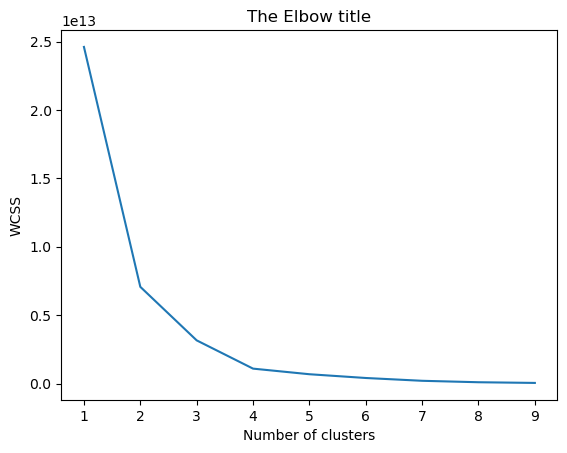

In [64]:
# Elbow method
data = pol_voivo.iloc[:, 2:4].values

wcss=[]
for i in range(1,10):
    kmeans = KMeans(i)
    kmeans.fit(data)
    wcss_iter = kmeans.inertia_
    wcss.append(wcss_iter)

number_clusters = range(1,10)
plt.plot(number_clusters,wcss)
plt.title('The Elbow title')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

I decided to choose 4 number of clusters based on the plot.
The chart below shows the performance of the k-means clusterinf based on population and number of cities.

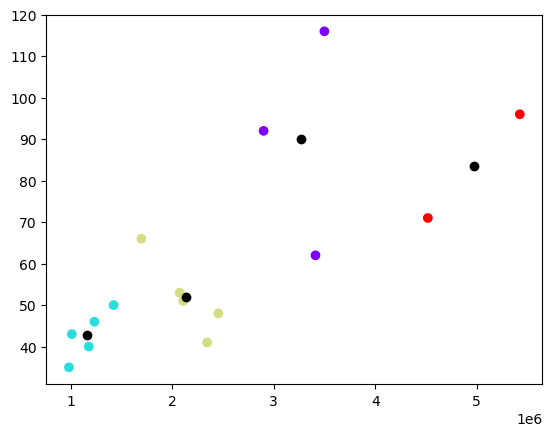

In [66]:
# K-means clustering based on population and number of cities
clusters = KMeans(n_clusters=4)
clusters.fit(data)
plt.scatter(data[:,0], data[:,1], c=clusters.labels_, cmap='rainbow')
plt.scatter(clusters .cluster_centers_[:,0] ,clusters.cluster_centers_[:,1], color='black')

###Creating a map
Finding coordinates to make the map centered:

In [22]:
# Creating centre points
x_map=pol_voivo.centroid.x.mean()
y_map=pol_voivo.centroid.y.mean()
print(x_map,y_map)

19.27277058578606 51.87640282577034


C:\Users\Kinga Chodorowska\AppData\Local\Temp\ipykernel_9008\1915197320.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  x_map=pol_voivo.centroid.x.mean()
C:\Users\Kinga Chodorowska\AppData\Local\Temp\ipykernel_9008\1915197320.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  y_map=pol_voivo.centroid.y.mean()


Next, I initilize the map.

In [74]:
# Drawing map
mapa = folium.Map(location=[y_map, x_map], zoom_start=6,tiles="Stamen Terrain")
folium.TileLayer('CartoDB positron',name="First map",control=False).add_to(mapa)
mapa

Then, I use Folium choropleth method to draw the choropleth map.

In [75]:
# Drawing map - adding labels and layers
folium.Choropleth(
    geo_data=pol_voivo,
    name="choropleth",
    data=pol_voivo,
    columns=["name", "pop_in_M"],
    key_on="feature.properties.name",
    fill_color="GnBu",
    fill_opacity=1,
    line_opacity=0.2,
    legend_name="Total Population (in Millions) By Voivodeship, 2020",
    smooth_factor=0
).add_to(mapa)

mapa

The last thing is to add pop-ups to the map. I want 

In [76]:
VOIVO = folium.features.GeoJson(
    pol_voivo,
    style_function=style_function, 
    control=False,
    highlight_function=highlight_function, 
    tooltip=folium.features.GeoJsonTooltip(
        fields=['name','pop_in_M','cities_no'],
        aliases=['Voivodeship: ','Population in M: ','Number of cities: '],
        style=("background-color: white; color: #333333; font-family: arial; font-size: 12px; padding: 10px;") 
    )
)
mapa.add_child(VOIVO)
mapa.keep_in_front(VOIVO)
folium.LayerControl().add_to(mapa)
mapa